In [10]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.feature_selection import VarianceThreshold
import pickle

In [14]:
feat_dir = 'data'
data_dir = 'data_ori'

In [18]:
gatrain = pd.read_csv(os.path.join(data_dir,'gender_age_train.csv'))
gatest = pd.read_csv(os.path.join(data_dir,'gender_age_test.csv'))

targetencoder = LabelEncoder().fit(gatrain.group)
y = targetencoder.transform(gatrain.group)
nclasses = len(targetencoder.classes_)

In [131]:
# Calculate CV score on Xtrain, y
def score_fit(X, clf = None, random_state = 12):
    if not clf: clf = LogisticRegression(C=0.02, multi_class='multinomial',solver='lbfgs', n_jobs=3)
        
    kf = StratifiedKFold(y, n_folds=3, shuffle=True, random_state=random_state)
    pred = np.zeros((y.shape[0],nclasses))
    for itrain, itest in kf:
        Xtr, Xte = X[itrain, :], X[itest, :]
        ytr, yte = y[itrain], y[itest]
        clf.fit(Xtr, ytr)
        pred[itest,:] = clf.predict_proba(Xte)
        #print("{:.5f}".format(log_loss(yte, pred[itest,:])))
    #print('')
    return log_loss(y, pred)

In [123]:
X = gatrain[['device_id']].merge( pd.read_csv(os.path.join(feat_dir, 'features_events_totals.csv')), on='device_id', how='left')
X.drop('device_id', axis=1, inplace=True)

In [124]:
X.head()

,n_events,r_hour_with_events,r_day_with_events,r_hour_grouped_with_events,r_event_weekend,r_event_day
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,0.005882,0.111111,0.041667,1.0,1.0
3,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN


In [218]:
feature_files1 = ['features_events_totals.csv',
                 'features_appid_totals.csv',
                 'features_label_app_count.csv',
                 'features_group_app_count.csv',
                 'features_geo.csv',
                 'features_events_per_day.csv',
                 'features_events_per_hour_grouped.csv',
                 'features_events_per_hour.csv',
                 'features_events_per_quarter.csv',
                 'features_events_per_quarter_grouped.csv']

feature_files2 = ['features_brand_model_bag',
                 'features_brand_bag',
                 'features_brand_model.csv',
                 'features_appid_installed',
                 'features_appid_active',
                 'features_appid_r_active',
                 'features_appid_installed_active',
                 'features_appid_installed_rel',
                 'features_appid_active_rel',
                 'features_label_app_installed',
                 'features_label_app_installed_prop',
                 'features_label_app_active_rel',
                 'features_label_app_more_active_week',
                'features_label_app_more_active_day',
                'features_group_app_installed_count.csv',
                'features_group_app_installed_prop.csv',
                'features_group_app_active_count.csv',
                'features_group_app_active_prop.csv',
                'features_group_app_active_rel.csv',]

feature_files = feature_files2 + feature_files1

In [219]:
def open_feature_file(fname, samples='train'):
    if fname[-3:] == 'csv':
        if samples=='train':
            X = gatrain[['device_id']].merge( pd.read_csv(os.path.join(feat_dir, fname)), on='device_id', how='left')
        else:
            X = gatest[['device_id']].merge( pd.read_csv(os.path.join(feat_dir, fname)), on='device_id', how='left')
            
        X.drop('device_id', axis=1, inplace=True)
        X.fillna(0, inplace=True)
        return X #csr_matrix(X.values)
    else:
        # Assume it is a pickle file
        with open(os.path.join(feat_dir, '{}_{}.pickle'.format(fname,samples)), 'rb') as f:
            return pickle.load(f)

def normalize(x):
    return (x - x.min())/(x.max() - x.min())

In [ ]:
include_if_higher = True
feat_to_include = ['features_brand_model_bag','features_brand_bag', 'features_appid_active']
scores_fw = []
labels = []
Xtrain = hstack([open_feature_file(f) for f in feat_to_include], format='csr')
score = score_fit(Xtrain)
oldscore = score
print score
scores_fw.append(score)
labels.append(feature_files[0])
for feat_file in set(feature_files)-set(feat_to_include):
    Xnew = open_feature_file(feat_file)
    print('Adding features of {}'.format(feat_file))
    print('\t {} features'.format(Xnew.shape[1]))
    
    if feat_file[-3:]=='csv':
        for c in Xnew.columns:
            
            print('\t Testing feature {}'.format(c))
            
            Xnew_c = Xnew[[c]]
            
            if Xnew_c.max()[0]>1:
                print('\t \t Max value is {} -> normalized'.format(Xnew_c.max()[0]))
                Xnew_c = normalize(Xnew_c)
            
            Xtrain_new = hstack([Xtrain, csr_matrix(Xnew_c.values)], format='csr')
            score = score_fit(Xtrain_new)
            print('\t \t new score:{:.5f}'.format(score))
            print('\t \t delta:{:.5f}'.format(score-oldscore))
            
            if score<oldscore and include_if_higher:
                Xtrain = Xtrain_new
                oldscore = score
                print('\t \t Included')
            else:
                print('\t \t Ignored')
            
            if include_if_higher:
                scores_fw.append(oldscore)
            else:
                scores_fw.append(score)
            labels.append(c)
            
    else:
        
        vs = [1e-6, 1e-5, 1e-4, 1e-3, 0]
        scores_vs = []
        for v in vs:
            print('\t Testing with variance treshold: {}'.format(v))
            selector = VarianceThreshold(v)
            selector.fit(Xnew)
            Xnew_l = selector.transform(Xnew)
            print('\t \t Now {} features'.format(Xnew_l.shape[1]))
        
            Xtrain_new = hstack([Xtrain, Xnew_l], format='csr')
            score = score_fit(Xtrain_new)
            scores_vs.append(score)
            print('\t \t new score: {:.5f}'.format(score))
        
        v_best = vs[scores_vs.index(min(scores_vs))]
        selector = VarianceThreshold(v_best)
        selector.fit(Xnew)
        Xnew = selector.transform(Xnew)
        Xtrain_new = hstack([Xtrain, Xnew], format='csr')
        score = score_fit(Xtrain_new)
        
        print('\t Best score with {}: {:.5f}'.format(v_best, score))
        
        if score<oldscore and include_if_higher:
            Xtrain = Xtrain_new
            oldscore = score
            print('\t Included')
        else:
            print('\t Ignored')
        
        if include_if_higher:
            scores_fw.append(oldscore)
        else:
            scores_fw.append(score)
        labels.append(feat_file)
    
#print('Doing backward')
#scores_bw = []

#for i in np.arange(len(feature_files)):
#    Xtrain = hstack([open_feature_file(x) for x in feature_files[i:len(feature_files)]], format='csr')
#    score = score_fit(Xtrain)
#    print score
#    scores_bw.append(score)

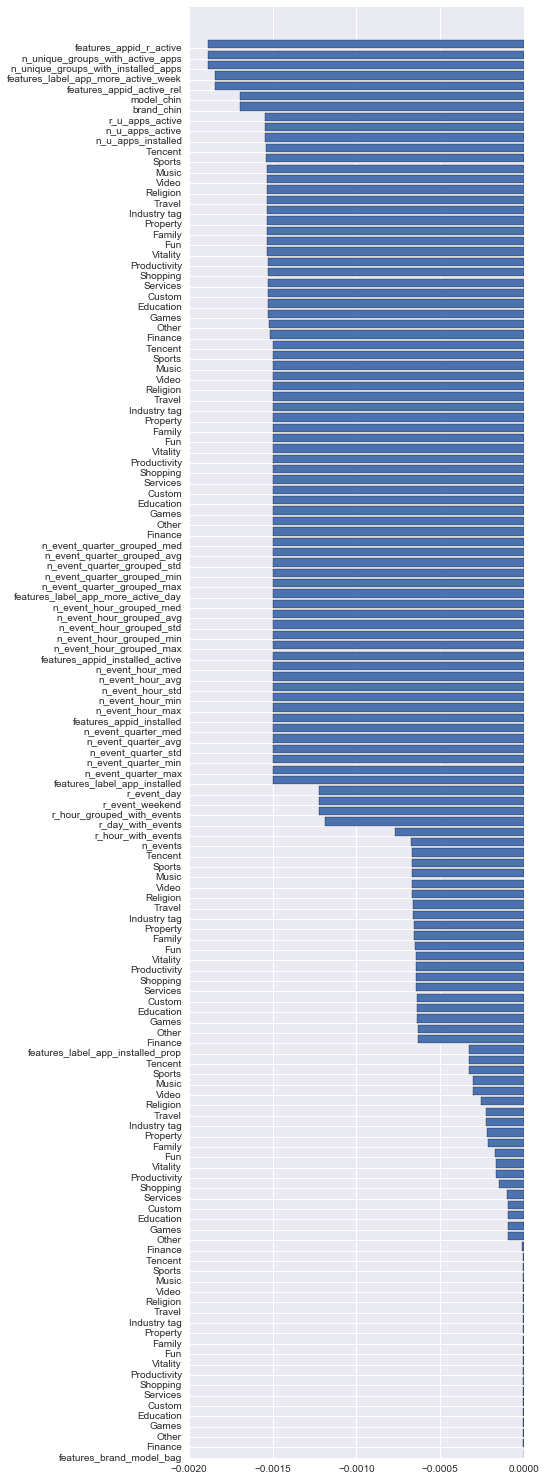

In [236]:
ind = np.arange(len(scores_fw))
plt.figure(figsize=(6,26))
plt.barh(ind, pd.Series(scores_fw)-scores_fw[0])
plt.yticks(ind,labels, rotation='horizontal')
a=1

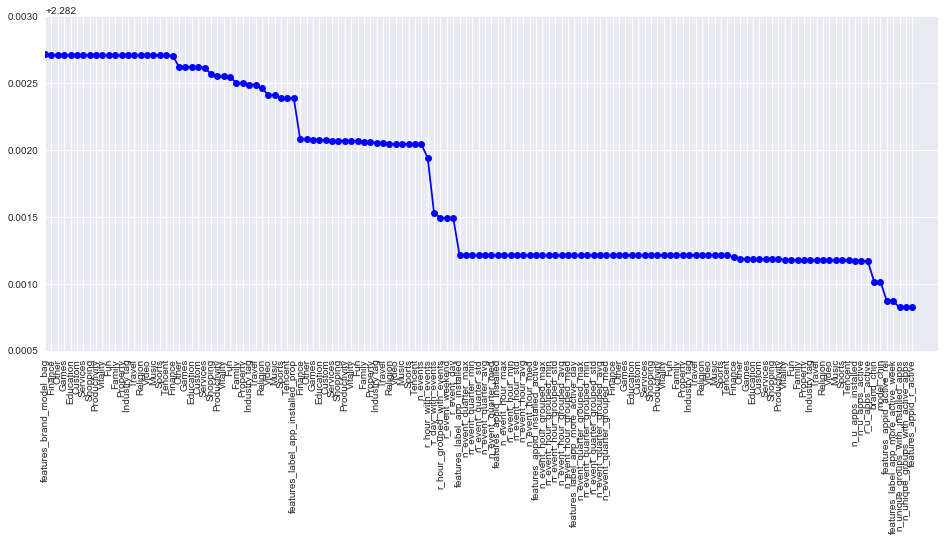

In [245]:
ind = np.arange(len(scores_fw))
plt.figure(figsize=(16,6))
plt.plot(ind, pd.Series(scores_fw),'bo-')
plt.xticks(ind,labels, rotation='vertical')
a=1

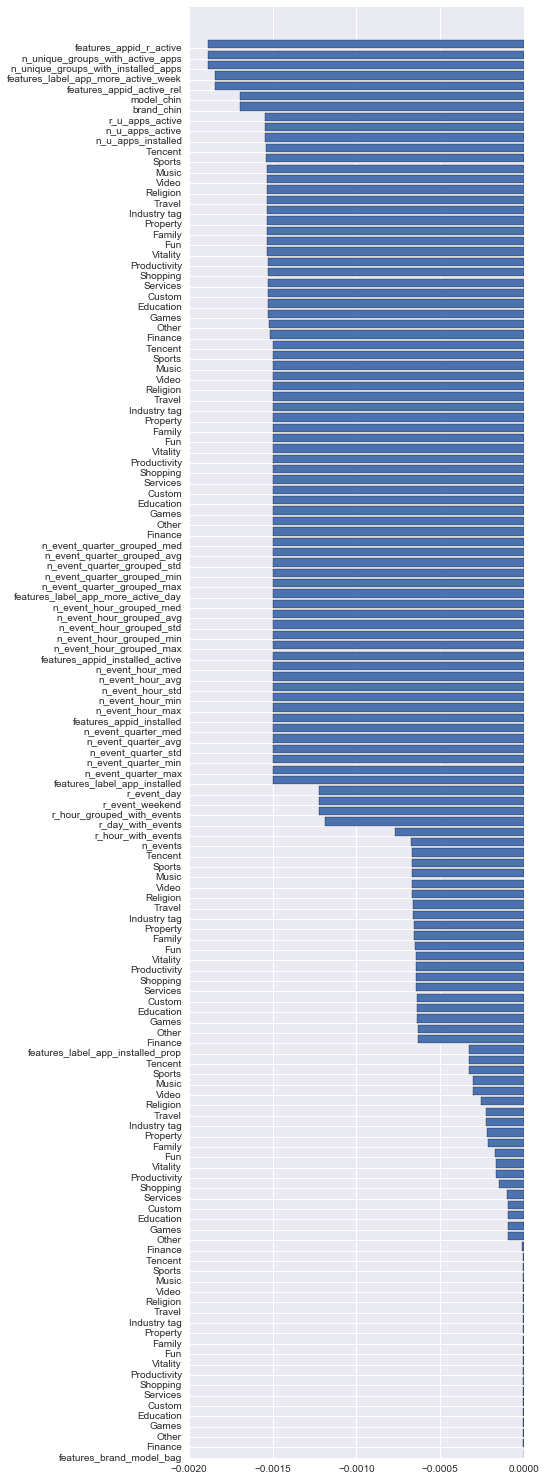

In [241]:
ind = np.arange(len(scores_fw))
plt.figure(figsize=(6,26))
plt.barh(ind, pd.Series(scores_fw)-scores_fw[0])
plt.yticks(ind,labels, rotation='horizontal')
a=1

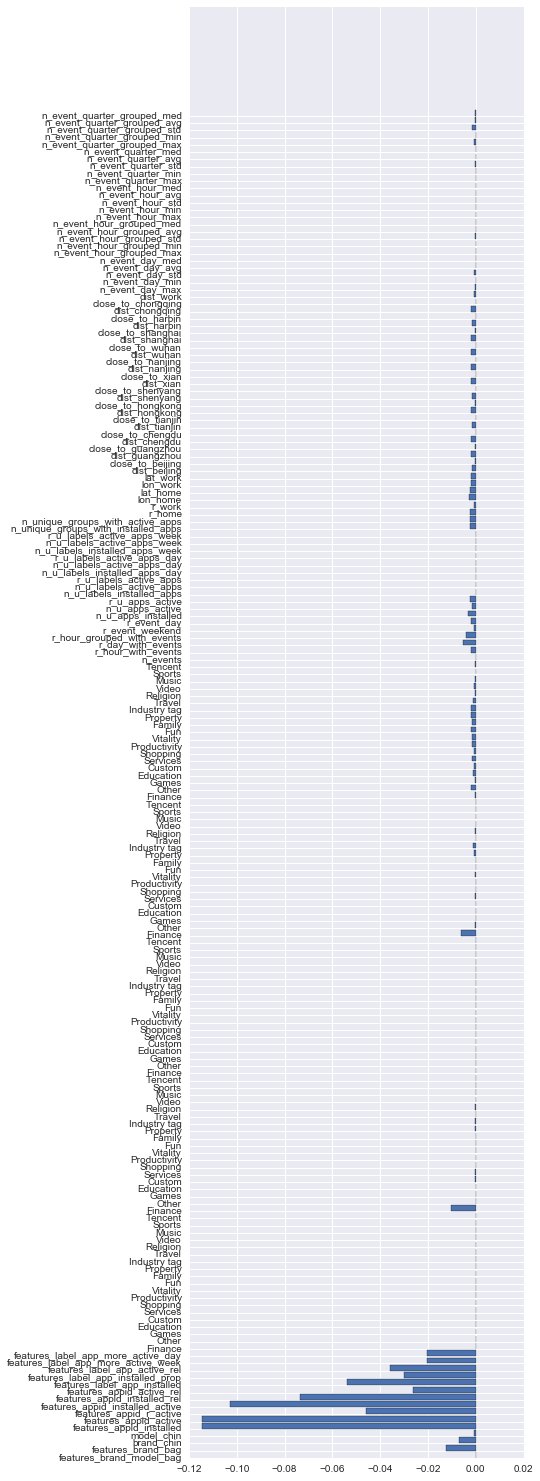

In [232]:
ind = np.arange(len(scores_fw))
plt.figure(figsize=(6,26))
plt.barh(ind, pd.Series(scores_fw)-scores_fw[0])
plt.yticks(ind,labels, rotation='horizontal')
a=1